# Welcome

Welcome to MobsPy tutorial notebooks. These notebooks will teach you the basics of using MobsPy, a language designed to simplifying the construction of chemical reaction networks. This tutorial will teach you how to define species, reactions, counts and rates. Afterwards, we will discuss the inner structure of MobsPy and how it simplifies modeling.

In [1]:
# !pip install mobspy --upgrade

from mobspy import *
import matplotlib.pyplot as plt
import PIL

# Meta-Reaction Syntax

In MobsPy, meta-reactions are used to define reactions and are constructed using Python operators and Base Species objects. The + operator sums reactants and products, while the * operator defines stoichiometry. The >> operator indicates the transformation of reactants to products, and the [] operator assigns a rate to the reaction. Species are assigned counts or concentrations using the species variable and the call operator ():

Compiling model
Starting Simulator
Simulation is Over


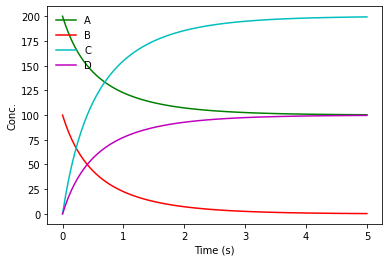

In [2]:
A, B, C, D = BaseSpecies()

# One molecule of A and one molecule of B becomes two molecules of C and one of D at a rate of 0.01
A + B >> 2*C + D [0.01]

# We start with 200 units of A and 100 units of B
A(200), B(100)
# Define the simulation using the given meta-species 
S = Simulation(A | B | C | D)
S.duration = 5
S.run()

# How MobsPy works?

MobsPy uses meta-species and meta-reactions to simplify models. Meta-species are simply set of species constructed with all possible states of a specie. Meta-reactions define multiple reactions by using sets or subsets of these meta-species. Moreover, MobsPy simplifies the definition of chemical reaction networks with a bottom-up approach. Base meta-species representing simple tasks are defined and then combined to form more complex meta-species. For example, to model the aging process, we can define a base meta-species, "Ager" and use the >> operator to represent the transformation from "young" to "old" with a given reaction constant rate.
The variable "u" is used to assign units to the given reaction constant rate.

In [3]:
Ager = BaseSpecies()

Ager.young >> Ager.old [1/10/u.year]
#Note that the characteristics young and old are automatically added to Ager when used with the . operator

To add characteristics to meta-species, we can use the dot operator.
Characteristics can be added both inside and outside reactions. In the example above, the "young" and "old" characteristics are added to the "Ager" meta-species using the dot operator while defining the aging reaction.

As an example of how to use the dot operator, we can create two new base species, "Colored" and "Location," and assign characteristics to them:

In [4]:
Colored, Location = BaseSpecies(2)

Colored.green, Colored.yellow, Colored.brown
Location.dense, Location.sparse

(<mobspy.modules.meta_class.Reacting_Species at 0x7fc319381fd0>,
 <mobspy.modules.meta_class.Reacting_Species at 0x7fc31f863c10>)

With MobsPy, it's possible to create meta-species and assign reactions to them without assigning characteristics. 
In this example, we use the provided meta-species Zero to define the Mortal meta-species, which represents death. 
Zero represents the absence of reactants or products in a reaction. 
To model a death rate higher for beings in the old state, we pass a function as a rate that returns reaction constant rates based on the state of the meta-species.

In [5]:
Mortal = BaseSpecies(1)

# Functions can be rates. Reactants will be passed to the function which will return a higher rate if it contains the
# charcteristic old
Mortal >> Zero [lambda r1: 1/u.year if r1.old else 0]

We can combine the previously defined base meta-species to construct a more complex one with all desired characteristics and reactions by multiplying the previously defined meta-species. For example, we can create a "Tree" meta-species that has both the characteristics and reactions of Ager, Colored, and Location, and Mortal:

In [6]:
Tree = Ager*Colored*Mortal*Location

The Tree meta-species is a model that incorporates the Mortal reaction for death and the Ager reaction for aging, as well as the Colored, Location and Ager characteristics. Therefore, the Tree meta-species can be in the following states:

**Tree.young.brown.dense, Tree.young.brown.sparse, \  
Tree.young.green.dense, Tree.young.green.sparse, \
Tree.young.yellow.dense, Tree.young.yellow.sparse, \
Tree.old.brown.dense, Tree.old.brown.sparse, \
Tree.old.green.dense, Tree.old.green.sparse, \
Tree.old.yellow.dense, Tree.old.yellow.sparse.**

MobsPy created these states through a vectorial representation. In this vector space, the species Ager, Location, and Colored represent the axes, and the characteristics define the coordinate markings on those axes. The characteristics are position according to the axes of the first meta-species they have been directly added in. 
So the young and old characteristic bellong to the Ager axis, the brown, green and yellow belong to the Colored axis, and finally the sparce and dense belong to the Location axis.
The vector space of Tree can be seen below:

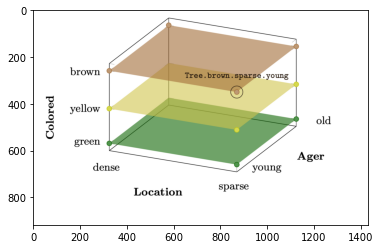

In [7]:
plt.imshow(PIL.Image.open('images/vectorial_space.png'))

All states partake in the meta-reactions from the base meta-species used to construct Tree to define reactions. For instance, the Ager meta-reaction yields the following six reactions:

**Tree.young.brown.dense -> Tree.old.brown.dense \
Tree.young.brown.sparse -> Tree.old.brown.sparse \
Tree.young.green.dense -> Tree.old.green.dense \
Tree.young.green.sparse -> Tree.old.green.sparse \
Tree.young.yellow.dense -> Tree.old.yellow.dense \
Tree.young.yellow.sparse -> Tree.old.yellow.sparse** 

When using the dot notation in the reactants, MobsPy performs a query and filters the states that do not contain the specified characteristics. When using the dot notation in the products, one specifies the coordinate on the vector space where the transformation should occur. Thus, the Ager reaction transforms young to old as those are the characteritics in the Ager vector axis.

To continue building upon this model, we add two more reactions to the new Tree meta-species. A competition reaction between Trees in the dense location where the older Trees kill the young threes and a replication reaction where old Trees generate new Trees.

In [8]:
# competition
Tree.dense.old + Tree.dense.young >> Tree.dense.old [1e-10*u.decimeter/u.year]
# replication
Tree.old >> Tree + Tree.young [0.1/u.year]

In MobsPy, the order of reactants and products has meaning. The order of reactants and products is used to generate the reactions from meta-reactions. 
The state of the first meta-species in the reactants will be used to generate the first product of the same meta-species. 
Further, the second reactant becomes the second product unless there are more products than reactants. 
In that case, if the products run out of corresponding reactants, MobsPy will cycle through the reactants and pick the first one again. 

For exemple, we show a diagram bellow for the reaction 2 * Meta_Species_1 + Meta_Species_2 >> Meta_Species_2 + 3 * Meta_Species_1. Here the first and second Meta_Species_1 from the product are assigned the states of the first and second Meta_Species_1 from the reactants, then the third Meta_Species_1 from the product will be assigned the state of the first
Meta_Species_1 from the reactant. Meta_Species_2 is not matched with Meta_Species one since they are different Meta_Species. The diagram follows:

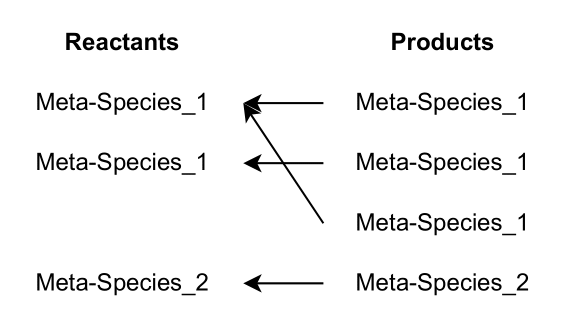

In [9]:
PIL.Image.open('images/Matching_Meta.png')

Consider the competition reaction Tree.dense.old + Tree.dense.young >> Tree.dense.old. Here, the order of the reactants indicates that the old Tree survives the competition and kills the young Tree, thus we preserve the state of the first Tree meta-species in the reaction. Thus, this meta-reaction yields the following reactions:

**Tree.brown.dense.old + Tree.brown.dense.young -> Tree.brown.dense.old \
Tree.brown.dense.old + Tree.green.dense.young -> Tree.brown.dense.old \
Tree.brown.dense.old + Tree.yellow.dense.young -> Tree.brown.dense.old \
Tree.green.dense.old + Tree.brown.dense.young -> Tree.green.dense.old \
Tree.green.dense.old + Tree.green.dense.young -> Tree.green.dense.old \
Tree.green.dense.old + Tree.yellow.dense.young -> Tree.green.dense.old \
Tree.yellow.dense.old + Tree.brown.dense.young -> Tree.yellow.dense.old \
Tree.yellow.dense.old + Tree.green.dense.young -> Tree.yellow.dense.old \
Tree.yellow.dense.old + Tree.yellow.dense.young -> Tree.yellow.dense.old**

On the other hand, in the replication reaction Tree.old >> Tree + Tree.young, the state of the first Tree is used to construct both products due to the round-robin cycle. As a result, the Trees of the products will retain the state of the first reactant. However, since a transformation is specified for the second Tree in the products, it will maintain its location and color, but its age will change to young, yielding the reactions:

**Tree.brown.dense.old -> Tree.brown.dense.old + Tree.brown.dense.young \
Tree.brown.sparse.old -> Tree.brown.sparse.old + Tree.brown.sparse.young \
Tree.green.dense.old -> Tree.green.dense.old + Tree.green.dense.young \
Tree.green.sparse.old -> Tree.green.sparse.old + Tree.green.sparse.young \
Tree.yellow.sparse.old -> Tree.yellow.sparse.old + Tree.yellow.sparse.young \
Tree.yellow.dense.old -> Tree.yellow.dense.old + Tree.yellow.dense.young** 

Finally, although the order of reactants has meaning, the queries can be performed in any order.

It is necessary to specify the meta-species used in the simulation. 
As the Ager, Location, Mortal, and Color were defined only to construct the Tree meta-species, they must not be considered in the simulation. Once the simulation object has been defined, one can configure the simulation using the dot operator. Below, we define and simulate the model:

In [11]:
# initial conditions, in this model version we only have green trees
Tree.dense(25), Tree.dense.old(25), Tree.sparse(25), Tree.sparse.old(25)
S = Simulation(Tree)
S.simulation_method = 'stochastic'
S.repetitions = 3
S.duration = 20*u.years
S.unit_x = 'year'
S.run()

Compiling model


AttributeError: Neither Quantity object nor its magnitude (1) has attribute 'convert'

The counts of resulting states are automatically mapped to the Three meta-species. MobsPy also provides in it's results the counts of the individual states. The results can be accessed in the following manner:

In [ ]:
print(S.results[Tree])

We also compile the model to show it in detail:

In [ ]:
print(S.compile())

One can see how MobsPy was able to reduce a 27 reaction model into three meta-reactions. 
Finally, one can acess the results inside the simulation object 

# Following Notebooks

In the following tutorials, we will revise in more detail some of the tools used here and explain other resources that can be further used to simplify models. 